## Skip-gram vs CBOW – Word Embeddings from Scratch

**Objetivo:** implementar modelos CBOW y Skip-gram desde cero en PyTorch, entrenarlos con el dataset Text8 (ya me lo dieron), y comparar las incrustaciones mediante t-SNE y UMAP.  
Documento y comenta cada bloque de código — lo que hace y por qué — para la entrega.

**Notas:**
- Estoy en Mac M2; usaré `mps` si está disponible (no hay CUDA).
- Simplificaré algunas opciones para que sea fácil de seguir.


In [2]:
import os
import re
import random
import math
from collections import Counter, defaultdict
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.manifold import TSNE
import umap

# Device: prefer mps (Mac M1/M2), luego cuda, luego cpu
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Usando device:", device)


Usando device: mps


### Data and pre-processing

Leeremos el archivo `text8` (me dijiste que ya te lo dieron — pon el path correcto). Haremos:
- lowercase y quitar puntuación simple
- tokenizar por whitespace
- eliminar palabras raras (freq < 5)
- limitar vocab a top 50k
- crear mappings word2idx y idx2word

Además: generaremos una lista de tokens filtrados lista para crear pares (center, contexts).


In [3]:
TEXT8_PATH = "text8"  

with open(TEXT8_PATH, "r", encoding="utf-8") as f:
    text = f.read()

text = text.lower()
text = re.sub(r"[^a-z0-9\s]", " ", text) 
tokens = text.split()

print("Tokens totales:", len(tokens))

min_freq = 5
counter = Counter(tokens)

tokens = [t for t in tokens if counter[t] >= min_freq]
print("Tokens después de filtrar rarezas:", len(tokens))

vocab_size_limit = 50000
most_common = counter.most_common(vocab_size_limit)
vocab = [w for w,_ in most_common]
vocab_set = set(vocab)

tokens = [t for t in tokens if t in vocab_set]

counter = Counter(tokens)
vocab = [w for w,_ in counter.most_common(vocab_size_limit)]
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for w,i in word2idx.items()}

print("Tamaño vocab final:", len(vocab))

Tokens totales: 17005207
Tokens después de filtrar rarezas: 16718844
Tamaño vocab final: 50000


### Generar pares de entrenamiento y DataLoader

- Para cada palabra central elegimos un tamaño de ventana aleatorio entre 2 y 5 (según lo pide la práctica).
- Para CBOW: guardamos (context_list, target_idx).
- Para Skip-gram: guardamos (target_idx, context_list).
- Guardamos ambos conjuntos por separado para poder entrenar cada modelo.
- Creamos un Dataset custom y un collate que convierta listas variables de contexto en tensores (y usa máscara o hace average).


In [ ]:
min_window = 2
max_window = 5

def generate_pairs(tokens, word2idx, min_w=2, max_w=5, max_samples=None):
    pairs_cbow = []  
    pairs_skip = []  
    N = len(tokens)
    for i in tqdm(range(N)):
        w = tokens[i]
        if w not in word2idx:
            continue
        window = random.randint(min_w, max_w)
        start = max(0, i - window)
        end = min(N, i + window + 1)
        context = []
        for j in range(start, end):
            if j == i:
                continue
            wj = tokens[j]
            if wj in word2idx:
                context.append(word2idx[wj])
        if len(context) == 0:
            continue
        target = word2idx[w]
        pairs_cbow.append((context, target))
        pairs_skip.append((target, context))
        if max_samples is not None and len(pairs_cbow) >= max_samples:
            break
    return pairs_cbow, pairs_skip

max_samples = None  
pairs_cbow, pairs_skip = generate_pairs(tokens, word2idx, min_window, max_window, max_samples)

print("Pares CBOW:", len(pairs_cbow), "Pares Skip:", len(pairs_skip))

100%|██████████| 16586825/16586825 [00:28<00:00, 581775.65it/s]

Pares CBOW: 16586825 Pares Skip: 16586825


Ahora el Dataset y collate

In [6]:
class CBOWDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        context, target = self.pairs[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

class SkipGramDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        target, context = self.pairs[idx]
        return torch.tensor(target, dtype=torch.long), torch.tensor(context, dtype=torch.long)

# Collate: agrupar listas de longitud variable
def collate_cbow(batch):
    contexts = [b[0] for b in batch]
    targets = torch.stack([b[1] for b in batch])
    max_len = max([c.size(0) for c in contexts])
    padded = torch.zeros(len(contexts), max_len, dtype=torch.long)
    mask = torch.zeros(len(contexts), max_len, dtype=torch.float)
    for i,c in enumerate(contexts):
        L = c.size(0)
        padded[i, :L] = c
        mask[i, :L] = 1.0
    return padded, mask, targets

def collate_skip(batch):
    targets = torch.stack([b[0] for b in batch])
    contexts = [b[1] for b in batch]
    max_len = max([c.size(0) for c in contexts])
    padded = torch.zeros(len(contexts), max_len, dtype=torch.long)
    mask = torch.zeros(len(contexts), max_len, dtype=torch.float)
    for i,c in enumerate(contexts):
        L = c.size(0)
        padded[i, :L] = c
        mask[i, :L] = 1.0
    return targets, padded, mask

batch_size = 512  
cbow_loader = DataLoader(CBOWDataset(pairs_cbow), batch_size=batch_size, shuffle=True, collate_fn=collate_cbow)
skip_loader = DataLoader(SkipGramDataset(pairs_skip), batch_size=batch_size, shuffle=True, collate_fn=collate_skip)


### Implementar modelos

- `Word2VecBaseModel` tendrá la embedding matrix (vocab_size x emb_dim).
- CBOW: promedia embeddings del contexto -> una capa lineal (emb_dim -> vocab_size) -> logits.
- Skip-gram: toma embedding del target -> proyecta (capa lineal) -> logits que predicen cada palabra del contexto. Para manejar múltiples contextos por ejemplo usaremos CrossEntropy aplicando la predicción repetida y promediando la pérdida sobre context positions.


In [7]:
class Word2VecBaseModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=100):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        # embedding para input (target or context)
        self.in_embeddings = nn.Embedding(vocab_size, emb_dim)
        # embedding para output (as logits)
        self.out_embeddings = nn.Embedding(vocab_size, emb_dim)
        # inicialización
        nn.init.xavier_uniform_(self.in_embeddings.weight)
        nn.init.xavier_uniform_(self.out_embeddings.weight)

    def get_input_embeddings(self):
        return self.in_embeddings.weight.data.cpu().numpy()

class CBOWModel(Word2VecBaseModel):
    def __init__(self, vocab_size, emb_dim=100):
        super().__init__(vocab_size, emb_dim)
        # una capa que usa el embedding promedio para producir logits sobre vocab
        self.linear = nn.Linear(emb_dim, vocab_size, bias=False)

    def forward(self, contexts, mask):
        emb = self.in_embeddings(contexts)  
        mask = mask.unsqueeze(-1) 
        summed = (emb * mask).sum(dim=1)  
        lens = mask.sum(dim=1).clamp(min=1.0) 
        averaged = summed / lens  
        logits = self.linear(averaged)  
        return logits

class SkipGramModel(Word2VecBaseModel):
    def __init__(self, vocab_size, emb_dim=100):
        super().__init__(vocab_size, emb_dim)

    def forward(self, centers, contexts, mask):
        # centers: (batch,) indices
        # contexts: (batch, max_ctx_len)
        # mask: (batch, max_ctx_len)
        center_emb = self.in_embeddings(centers)  
        # obtener embeddings de contexto (batch, max_ctx_len, emb_dim)
        context_embs = self.out_embeddings(contexts)

        batch, max_len, emb_dim = context_embs.size()

        center_exp = center_emb.unsqueeze(1).expand(-1, max_len, -1)

        logits = torch.matmul(center_exp, self.out_embeddings.weight.t())  
        # Para la loss usaremos CrossEntropy, que espera (N, C, ...) y targets con shape (N, ...)
        return logits  

### Entrenamiento

Definimos funciones de entrenamiento separadas para CBOW y Skip-gram  
- Para CBOW: logits (batch, vocab) y target (batch,) -> CrossEntropyLoss.
- Para Skip-gram: logits (batch, max_len, vocab) -> reacomodamos a (batch*max_len, vocab) y targets (batch*max_len), aplicamos máscara para ignorar paddings.
Registramos pérdida por epoch y mostramos curvas.

In [8]:
def train_cbow(model, dataloader, epochs=5, lr=1e-3, device=device):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    model.train()
    for epoch in range(1, epochs+1):
        running = 0.0
        pbar = tqdm(enumerate(dataloader), total=len(dataloader))
        for i, (contexts, mask, targets) in pbar:
            contexts = contexts.to(device)
            mask = mask.to(device)
            targets = targets.to(device)
            opt.zero_grad()
            logits = model(contexts, mask) 
            loss = criterion(logits, targets)
            loss.backward()
            opt.step()
            running += loss.item()
            pbar.set_description(f"CBOW Epoch {epoch} Loss {running/(i+1):.4f}")
        avg = running / len(dataloader)
        losses.append(avg)
    return losses

def train_skipgram(model, dataloader, epochs=5, lr=1e-3, device=device):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction='none')  
    losses = []
    model.train()
    for epoch in range(1, epochs+1):
        running = 0.0
        pbar = tqdm(enumerate(dataloader), total=len(dataloader))
        for i, (targets, contexts, mask) in pbar:
            targets = targets.to(device)  
            contexts = contexts.to(device)  
            mask = mask.to(device)  
            opt.zero_grad()
            logits = model(targets, contexts, mask)  
            batch, max_len, vocab_size = logits.size()
            
            logits_flat = logits.view(batch*max_len, vocab_size)
            
            targets_flat = contexts.view(-1)  
            losses_flat = criterion(logits_flat, targets_flat)  

            mask_flat = mask.view(-1)
            masked_loss = (losses_flat * mask_flat).sum() / (mask_flat.sum() + 1e-9)
            masked_loss.backward()
            opt.step()
            running += masked_loss.item()
            pbar.set_description(f"Skip Epoch {epoch} Loss {running/(i+1):.4f}")
        avg = running / len(dataloader)
        losses.append(avg)
    return losses

Ejemplo:

In [ ]:
emb_dim = 50
epochs = 1
# Inicializar modelos
cbow_model = CBOWModel(len(vocab), emb_dim=emb_dim)
skip_model = SkipGramModel(len(vocab), emb_dim=emb_dim)

# Entrenar CBOW (puedes comentar/ejecutar uno por vez)
losses_cbow = train_cbow(cbow_model, cbow_loader, epochs=epochs, lr=5e-3)

CBOW Epoch 1 Loss 6.2477: 100%|██████████| 32397/32397 [2:04:47<00:00,  4.33it/s]    


In [17]:
#losses_skip = train_skipgram(skip_model, skip_loader, epochs=epochs, lr=5e-3)

In [23]:
# Extraer las representaciones de palabras
word_embeddings = ((cbow_model.in_embeddings.weight + cbow_model.out_embeddings.weight) / 2).detach().cpu().numpy()
print(f"Forma de la matriz de embeddings: {word_embeddings.shape}")

Forma de la matriz de embeddings: (50000, 50)


In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Elegimos las N palabras más frecuentes para visualizar
N = 300  # puedes ajustar entre 200–500
selected_indices = np.arange(N)
selected_embeddings = word_embeddings[selected_indices]

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
reduced = tsne.fit_transform(selected_embeddings)

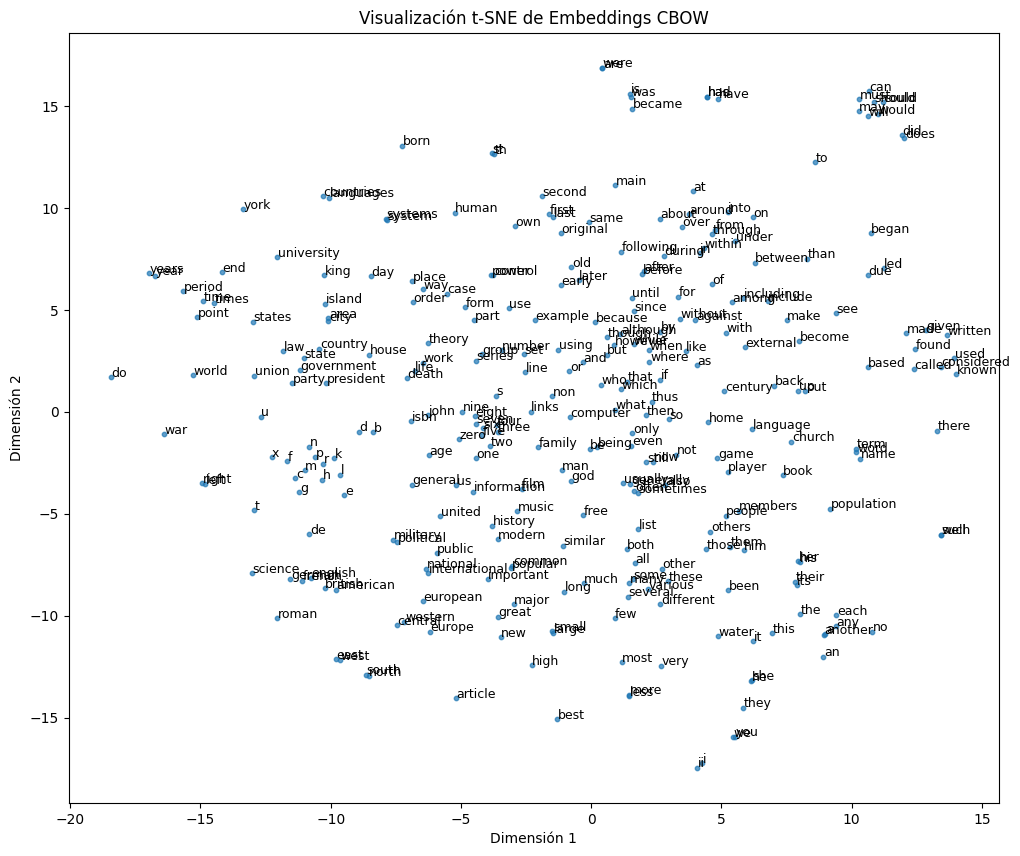

In [ ]:
import matplotlib.pyplot as plt

# Selecciona las palabras correspondientes
words = [idx2word[i] for i in selected_indices]

plt.figure(figsize=(12, 10))
plt.scatter(reduced[:, 0], reduced[:, 1], s=10, alpha=0.7)

for i, word in enumerate(words):
    plt.text(reduced[i, 0] + 0.02, reduced[i, 1] + 0.02, word, fontsize=9)

plt.title("Visualización t-SNE de Embeddings CBOW")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.show()

/Users/isabelvalladolid/Documents/MineriaTextos/Labs/Word-Embeddings-from-Scratch/.venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


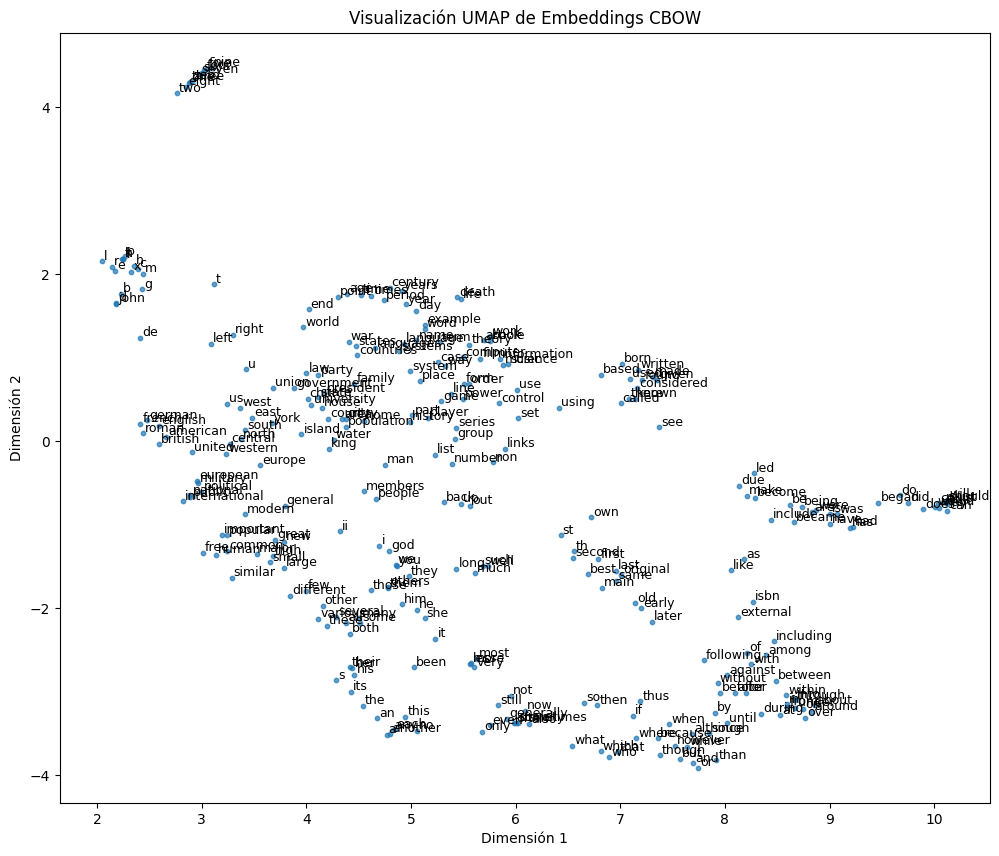

In [27]:
import umap

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
reduced_umap = umap_model.fit_transform(selected_embeddings)

plt.figure(figsize=(12, 10))
plt.scatter(reduced_umap[:, 0], reduced_umap[:, 1], s=10, alpha=0.7)

for i, word in enumerate(words):
    plt.text(reduced_umap[i, 0] + 0.02, reduced_umap[i, 1] + 0.02, word, fontsize=9)

plt.title("Visualización UMAP de Embeddings CBOW")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.show()

En este bloque se extraen los vectores de palabras aprendidos por el modelo CBOW y se reducen a dos dimensiones usando t-SNE o UMAP.
Esto permite visualizar la estructura semántica de los embeddings: palabras con significados similares deberían agruparse en regiones cercanas del espacio.
Finalmente, se grafican entre 200 y 500 palabras frecuentes, anotando sus etiquetas para observar posibles clústeres semánticos.

### Curvas de pérdida

Ploteamos la pérdida por epoch para cada modelo

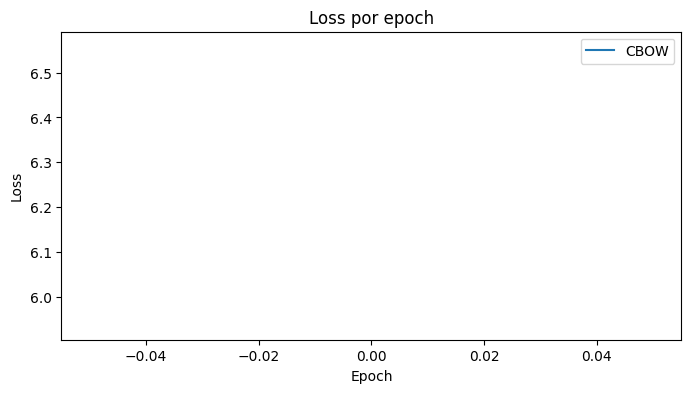

In [19]:
plt.figure(figsize=(8,4))
plt.plot(losses_cbow, label="CBOW")
#plt.plot(losses_skip, label="SkipGram")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss por epoch")
plt.show()

### Evaluación cualitativa (vecinos por similitud coseno)

- Extraemos embeddings finales (podemos sumar `in` y `out` si se desea, o usar `in_embeddings`)
- Para cada palabra ancla (por ejemplo "king", "apple", "run", "doctor") calculamos las top-10 palabras más similares por coseno
- Mostrar resultado para CBOW y Skip-gram

In [ ]:
import torch.nn.functional as F

def get_embeddings_from_model(model):
    # combinar in_embeddings y out_embeddings: (in + out) / 2
    with torch.no_grad():
        in_w = model.in_embeddings.weight.data.cpu()  # (vocab, emb_dim)
        out_w = model.out_embeddings.weight.data.cpu()
        emb = (in_w + out_w) / 2.0
        
        emb = F.normalize(emb, p=2, dim=1)
    return emb  

def most_similar(emb_matrix, word, word2idx, idx2word, topk=10):
    if word not in word2idx:
        return []
    vec = emb_matrix[word2idx[word]].unsqueeze(0)  # (1, emb_dim)
    sims = torch.matmul(emb_matrix, vec.t()).squeeze(1)  # (vocab,)
    topk_idx = torch.topk(sims, topk+1).indices.tolist()  # include itself
    result = []
    for idx in topk_idx:
        w = idx2word[idx]
        if w == word:
            continue
        result.append((w, float(sims[idx])))
        if len(result) >= topk:
            break
    return result

# Obtener embeddings
emb_cbow = get_embeddings_from_model(cbow_model)
emb_skip = get_embeddings_from_model(skip_model)

anchor_words = ["king", "apple", "run", "doctor"]
for anchor in anchor_words:
    print(f"\nCBOW vecinos para '{anchor}':")
    for w, s in most_similar(emb_cbow, anchor, word2idx, idx2word, topk=10):
        print(f"  {w}  (sim={s:.4f})")
    print(f"\nSkipGram vecinos para '{anchor}':")
    for w, s in most_similar(emb_skip, anchor, word2idx, idx2word, topk=10):
        print(f"  {w}  (sim={s:.4f})")

### t-SNE y UMAP para visualizar embeddings

- Seleccionamos las N palabras más frecuentes (p. ej. 500)
- Reducimos dimensionalidad con t-SNE y con UMAP
- Graficamos y anotamos las palabras. Para legibilidad anotamos sólo algunas o usamos zoom

In [ ]:
topN = 500
selected_idx = list(range(min(topN, len(vocab))))
selected_words = [idx2word[i] for i in selected_idx]

# Convertir a numpy
emb_cbow_np = emb_cbow[selected_idx].numpy()
emb_skip_np = emb_skip[selected_idx].numpy()

# t-SNE
tsne = TSNE(n_components=2, init='random', random_state=42, perplexity=30)
tsne_cbow = tsne.fit_transform(emb_cbow_np)
tsne_skip = tsne.fit_transform(emb_skip_np)

# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_cbow = reducer.fit_transform(emb_cbow_np)
umap_skip = reducer.fit_transform(emb_skip_np)

# Función de plot con anotaciones
def plot_2d(X, words, title, annotate_every=10):
    plt.figure(figsize=(10,8))
    plt.scatter(X[:,0], X[:,1], s=8)
    for i,w in enumerate(words):
        if i % annotate_every == 0:  # anotar cada n para no saturar
            plt.text(X[i,0], X[i,1], w, fontsize=8)
    plt.title(title)
    plt.show()

# Mostrar
plot_2d(tsne_cbow, selected_words, "t-SNE CBOW (top words)", annotate_every=5)
plot_2d(tsne_skip, selected_words, "t-SNE Skip-gram (top words)", annotate_every=5)
plot_2d(umap_cbow, selected_words, "UMAP CBOW (top words)", annotate_every=5)
plot_2d(umap_skip, selected_words, "UMAP Skip-gram (top words)", annotate_every=5)

## Análisis y conclusiones

- Compara las tablas de vecinos para cada ancla: ¿CBOW o Skip-gram captura mejor los sinónimos o palabras semánticas?
- Observa las gráficas t-SNE/UMAP: busca cluster semánticos (p. ej. colores, comida, rey/reina/monarquía, verbos).
- Eficiencia: Skip-gram tiende a funcionar mejor con menos datos para relaciones semánticas raras; CBOW suele entrenar más rápido y es más estable.
